In [13]:
import sys
sys.path.append('../..'); sys.path.append('../'); 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers


In [14]:
num_objects = 64
n = 10000
X = np.zeros((n, 2), dtype=int)
y = np.zeros(n, dtype=int)

for i in np.arange(n):
    context = np.random.choice(range(num_objects), size=1)[0]
    target = np.random.choice(range(num_objects), size=1)[0]
    X[i, 0] = context
    X[i, 1] = target
    y[i] = target >= context



In [15]:
from sklearn.model_selection import train_test_split
test_size = 0.2
val_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size/(1-test_size))


In [16]:
class ObjEmbedding(tf.keras.layers.Layer):
  def __init__(self, num_objects, embedding_dim):
    super(ObjEmbedding, self).__init__()

    self.num_objects = num_objects
    self.embedding_dim = embedding_dim

    normal_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=.1, seed=1)
    self.source_embedding = tf.Variable(
       normal_initializer(shape=(self.embedding_dim, self.num_objects)),
       trainable=True)
    self.target_embedding = tf.Variable(
       normal_initializer(shape=(self.embedding_dim, self.num_objects)),
       trainable=True)

    self.compute_probs()

  def compute_probs(self):
    inner_prods = tf.matmul(tf.transpose(self.source_embedding), self.target_embedding)
    #inner_prods = tf.linalg.set_diag(inner_prods, self.num_objects*[-1e10])
    self.probs = tf.nn.sigmoid(inner_prods)

  def call(self, input):
    self.compute_probs()
    u = tf.one_hot(input[:,0], self.num_objects)
    v = tf.one_hot(input[:,1], self.num_objects)
    outputs = tf.linalg.tensor_diag_part(tf.matmul(tf.matmul(u, self.probs), tf.transpose(v)))
    return outputs


In [17]:
num_objects = 64
embedding_dim = 32
inputs = tf.keras.Input(shape=(2,), dtype=tf.int64)
outputs = ObjEmbedding(num_objects, embedding_dim)(inputs)
model = tf.keras.Model(inputs, outputs, name='relational_embedder')
model.summary()


Model: "relational_embedder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 obj_embedding_1 (ObjEmbeddi  (None,)                  4096      
 ng)                                                             
                                                                 
Total params: 4,096
Trainable params: 4,096
Non-trainable params: 0
_________________________________________________________________


In [18]:
create_opt = lambda : tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=create_opt(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics='binary_accuracy')


In [19]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=20, batch_size=64)

Epoch 1/20
110/110 [==============================] - 1s 3ms/step - loss: 0.7170 - binary_accuracy: 0.5357 - val_loss: 0.7085 - val_binary_accuracy: 0.5844
Epoch 2/20
110/110 [==============================] - 0s 2ms/step - loss: 0.7138 - binary_accuracy: 0.6702 - val_loss: 0.7049 - val_binary_accuracy: 0.7037
Epoch 3/20
110/110 [==============================] - 0s 1ms/step - loss: 0.7069 - binary_accuracy: 0.8245 - val_loss: 0.6956 - val_binary_accuracy: 0.8561
Epoch 4/20
110/110 [==============================] - 0s 1ms/step - loss: 0.6906 - binary_accuracy: 0.9275 - val_loss: 0.6738 - val_binary_accuracy: 0.9246
Epoch 5/20
110/110 [==============================] - 0s 1ms/step - loss: 0.6598 - binary_accuracy: 0.9479 - val_loss: 0.6379 - val_binary_accuracy: 0.9373
Epoch 6/20
110/110 [==============================] - 0s 1ms/step - loss: 0.6202 - binary_accuracy: 0.9540 - val_loss: 0.6000 - val_binary_accuracy: 0.9393
Epoch 7/20
110/110 [==============================] - 0s 1ms/ste

In [20]:
out = model.predict(X_test)
yhat = [int(out[i] > 0.5) for i in range(len(out))]
np.mean(yhat == y_test)

63/63 [==============================] - 0s 843us/step


0.9875

[34 36 35 35 35 36 36 35 36 40 40 53 44 52 52 49 53 52 53 55 53 53 55 55
 51 55 52 52 55 55 59 59 54 59 60 62 60 60 62 55 59 59 59 59 59 62 62 60
 60 62 62 62 62 62 63 60 62 62 62 62 62 61 62 63]


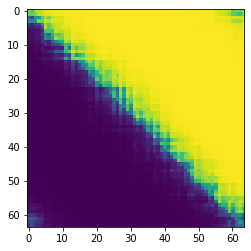

In [21]:
%matplotlib inline
model.layers[1].compute_probs()

plt.imshow(model.layers[1].probs)
print(np.argmax(model.layers[1].probs, axis=1))

In [22]:
embedder = model.layers[1]
inner_prods = tf.matmul(tf.transpose(embedder.source_embedding), embedder.target_embedding)
probs = tf.nn.sigmoid(inner_prods)
attention_weights = tf.nn.softmax(inner_prods, axis=1)



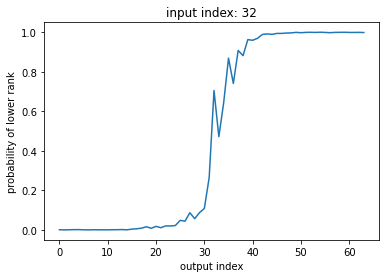

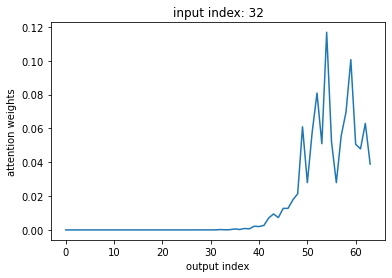

1.0

In [23]:
i = 32
plt.plot(np.arange(embedder.num_objects), probs[i,:])
plt.title('input index: %d' % i)
plt.xlabel('output index')
plt.ylabel('probability of lower rank')
plt.show()

plt.plot(np.arange(embedder.num_objects), attention_weights[i,:])
plt.title('input index: %d' % i)
plt.xlabel('output index')
plt.ylabel('attention weights')
plt.show()
np.sum(attention_weights[i,:])

(64, 10)

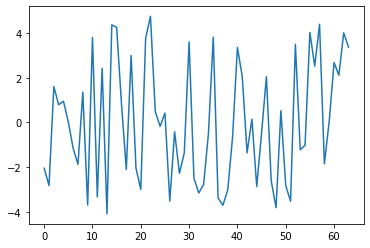

In [24]:
S = model.layers[1].source_embedding.numpy()
T = model.layers[1].target_embedding.numpy()
ST = np.vstack((S, T))


from sklearn.decomposition import PCA
pca = PCA(10).fit(ST)
ratio = pca.explained_variance_ratio_.sum()
pcs = pca.fit_transform(ST)
pcs.shape
plt.plot(np.arange(pcs.shape[0]), pcs[:,1])
pcs.shape
